In [4]:
import numpy as np
import torch
from torch.functional import norm
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from np_utils import simple_data, curved_data, planck_des_data
from torch_utils import rotation_test, get_limits, TrainUtil
from tension_net import TensionNet, TensionNet1, TensionNet2, TensionNet3
from tension_quantify import GaussianKDE, BayesFactorKDE, SuspiciousnessKDE, sigma_from_logS
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from anesthetic import NestedSamples

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rc('text', usetex=True)


In [10]:
def flatten_prior(XA_1d, XB_1d, X_prior_1d, weights=None):
    kde = gaussian_kde(
        X_prior_1d,
        weights=(weights["X_prior"].cpu().detach().numpy()
                 if weights else None)
    )
    X_all = np.concatenate((XA_1d, XB_1d, X_prior_1d))
    pad = (np.max(X_all) - np.min(X_all)) / 100
    x = np.linspace(np.min(X_all) - pad, np.max(X_all) + pad, 1000)
    pdf = kde(x)
    cdf = np.cumsum(pdf)
    cdf /= np.max(cdf)
    cdf_f = interp1d(x, cdf)

    XA_1d = cdf_f(XA_1d)
    XB_1d = cdf_f(XB_1d)
    X_prior_1d = cdf_f(X_prior_1d)

    return XA_1d, XB_1d, X_prior_1d

In [7]:
params = ["omegabh2", "omegam", "H0", "tau", "sigma8", "ns"]
param_labels = [r"$\Omega_b h^2$", r"$\Omega_m$", r"$H_0$", r"$\tau$", r"$\sigma_8$", r"$n_s$"]
param_pairs = []
for i in range(len(params)):
    for j in range(i + 1, len(params)):
        param_pairs.append([i, j])

(X0, X0_weights, X1, X1_weights, X_prior, X_prior_weights,
 params, param_means, norm_factors, param_stds) = planck_des_data(
     params=params, div_max=True, std=True
)
weights = {"XA": X0_weights, "XB": X1_weights, "X_prior": X_prior_weights}
param_means = torch.tensor(param_means).float().to(device)
norm_factors = torch.tensor(norm_factors).float().to(device)

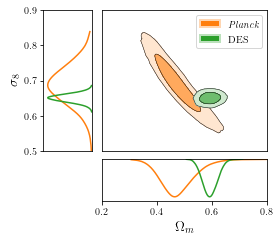

In [33]:
# fig, axs = plt.subplots(figsize=(4, 3.5))
# kde_contour_plot_2d(axs, X1[:, 1], X1[:, 4], weights=X1_weights, color="tab:orange", label=r"$\textrm{\textit{Planck}}$")
# kde_contour_plot_2d(axs, X0[:, 1], X0[:, 4], weights=X0_weights, color="tab:green", label=r"$\textrm{DES}$")
# axs.set_xlim([0.2, 0.8])
# axs.set_ylim([0.5, 0.9])
# axs.set_xlabel(param_labels[1])
# axs.set_ylabel(param_labels[4])
# axs.legend()
# fig.savefig("omegam_sigma8.png", dpi=300)

fig = plt.figure(figsize=(4, 3.5))
outer = gridspec.GridSpec(4, 4)
main_ax = plt.Subplot(fig, outer[:-1, 1:])
y_ax = plt.Subplot(fig, outer[:-1, 0])
x_ax = plt.Subplot(fig, outer[-1, 1:])
main_ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
main_ax.tick_params(axis='y', which='both', left=False, labelleft=False)
y_ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
x_ax.tick_params(axis='y', which='both', left=False, labelleft=False)
fig.add_subplot(main_ax)
fig.add_subplot(y_ax)
fig.add_subplot(x_ax)

kde_contour_plot_2d(main_ax, X1[:, 1], X1[:, 4], weights=X1_weights, color="tab:orange", label=r"$\textrm{\textit{Planck}}$")
kde_contour_plot_2d(main_ax, X0[:, 1], X0[:, 4], weights=X0_weights, color="tab:green", label=r"$\textrm{DES}$")
kde_plot_1d(y_ax, X1[:, 4], weights=X1_weights, color="tab:orange")
kde_plot_1d(y_ax, X0[:, 4], weights=X0_weights, color="tab:green")
newx = y_ax.lines[0].get_ydata()
newy = y_ax.lines[0].get_xdata()
y_ax.lines[0].set_xdata(newx)
y_ax.lines[0].set_ydata(newy)
newx = y_ax.lines[1].get_ydata()
newy = y_ax.lines[1].get_xdata()
y_ax.lines[1].set_xdata(newx)
y_ax.lines[1].set_ydata(newy)
kde_plot_1d(x_ax, X1[:, 1], weights=X1_weights, color="tab:orange")
kde_plot_1d(x_ax, X0[:, 1], weights=X0_weights, color="tab:green")

xlims = [0.2, 0.8]
ylims = [0.5, 0.9]
y_ax.set_xlim([0, 1.1])
y_ax.set_ylim(ylims)
x_ax.set_ylim([0, 1.1])
x_ax.set_xlim(xlims)
y_ax.invert_xaxis()
x_ax.invert_yaxis()
main_ax.set_xlim(xlims)
main_ax.set_ylim(ylims)

y_ax.set_ylabel(param_labels[4], fontsize=14)
x_ax.set_xlabel(param_labels[1], fontsize=14)
main_ax.legend()
fig.savefig("plots/omegam_sigma8.png", dpi=300)

## Gradient

In [6]:
from torch.autograd import Variable

all_grads_0 = torch.empty(0, 6)
for i in range(train_util_R.XA_tnsr.shape[0]):
    row = Variable(train_util_R.XA_tnsr[i, :], requires_grad=True)
    out = tension_R(row)
    out.backward(retain_graph=True)
    all_grads_0 = torch.cat((all_grads_0, row.grad[None]))

all_grads_1 = torch.empty(0, 6)
for i in range(train_util_R.XB_tnsr.shape[0]):
    row = Variable(train_util_R.XB_tnsr[i, :], requires_grad=True)
    out = tension_R(row)
    out.backward(retain_graph=True)
    all_grads_1 = torch.cat((all_grads_1, row.grad[None]))

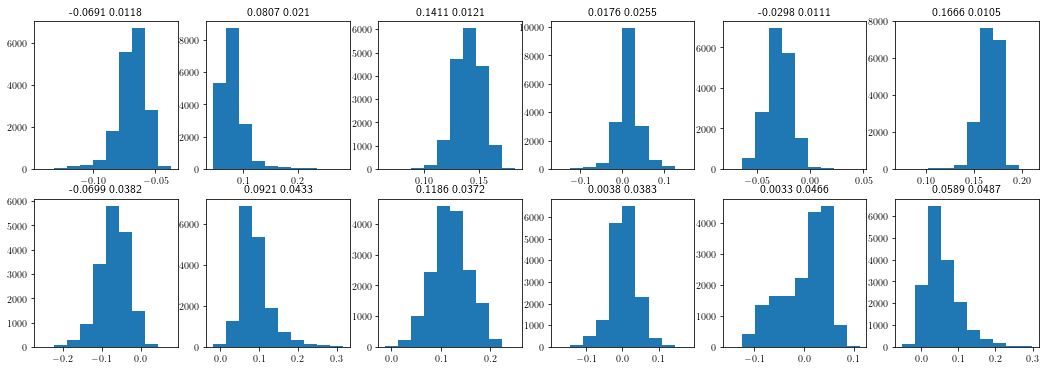

In [33]:
fig, axs = plt.subplots(2, 6, figsize=(18, 6))
all_grads_0_np = all_grads_0.detach().numpy()
all_grads_1_np = all_grads_1.detach().numpy()
mean_0 = np.average(all_grads_0_np, weights=X0_weights, axis=0)
mean_1 = np.average(all_grads_1_np, weights=X1_weights, axis=0)
std_0 = np.sqrt(np.average((all_grads_0_np - mean_0)**2, weights=X0_weights, axis=0))
std_1 = np.sqrt(np.average((all_grads_1_np - mean_1)**2, weights=X1_weights, axis=0))

for i in range(6):
    axs[0, i].hist(all_grads_0_np[:, i])
    axs[0, i].set_title(f"{round(mean_0[i], 4)} {round(std_0[i], 4)}")
    axs[1, i].hist(all_grads_1_np[:, i])
    axs[1, i].set_title(f"{round(mean_1[i], 4)} {round(std_1[i], 4)}")

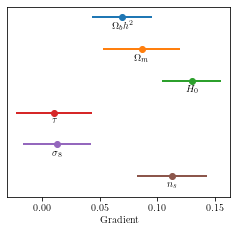

In [57]:
means = (mean_0 + mean_1) / 2
stds = (std_0 + std_1) / 2

ys = [7.5, 6, 4.5, 3, 1.5, 0]
fig, axs = plt.subplots(figsize=(4, 3.5))
for i in range(6):
    axs.scatter(np.abs(means[i]), ys[i])
    axs.plot([np.abs(means[i]) - stds[i], np.abs(means[i]) + stds[i]], [ys[i], ys[i]], linewidth=2)
    axs.annotate(param_labels[i], xy=(np.abs(means[i]), ys[i] - 0.5), ha='center', fontsize=10)

axs.set_ylim([-1, 8])
axs.tick_params(axis='y', which='both', left=False, labelleft=False)
axs.set_xlabel(r"$\textrm{Gradient}$")

fig.savefig("plots/grads.png", dpi=300)

## Sigma

In [4]:
tension_R = TensionNet1(6, hidden_size=4096)
tension_R.load_state_dict(torch.load("plots/six_2/six_13.pt", map_location=device))
criterion = BayesFactorKDE(device)
optimizer = optim.Adam(tension_R.parameters(), lr=0.001)

train_util_R = TrainUtil(tension_R, optimizer, criterion, device, 
                        data_labels=[r"$Planck$", r"\rm{DES}", r"\rm{Prior}"])
train_util_R.losses = np.loadtxt(f"plots/six_2/six_{i}_loss.csv", delimiter=",")

train_util_R.XA = X0
train_util_R.XB = X1
train_util_R.X_prior = X_prior
train_util_R.weights = {}
train_util_R.weights["XA"] = torch.tensor(X0_weights).to(device).float()
train_util_R.weights["XB"] = torch.tensor(X1_weights).to(device).float()
train_util_R.weights["X_prior"] = torch.tensor(X_prior_weights).to(device).float()

train_util_R.XA_tnsr = torch.tensor(X0).to(device).float()
train_util_R.XB_tnsr = torch.tensor(X1).to(device).float()
train_util_R.X_prior_tnsr = torch.tensor(X_prior).to(device).float()

Text(0.5, 1.0, 'Marginalised 1d distribution - flat prior')

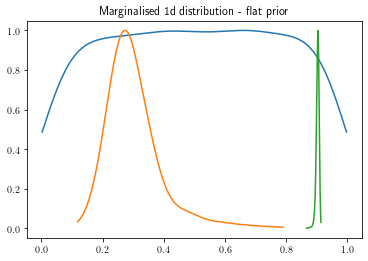

In [5]:
fig, axs = plt.subplots()

XA_1d = train_util_R.net(train_util_R.XA_tnsr).squeeze().cpu().detach().numpy()
XB_1d = train_util_R.net(train_util_R.XB_tnsr).squeeze().cpu().detach().numpy()
X_prior_1d = (train_util_R.net(train_util_R.X_prior_tnsr).squeeze().cpu()
                .detach().numpy())

XA_1d, XB_1d, X_prior_1d = train_util_R.flatten_prior(XA_1d, XB_1d,
                                                      X_prior_1d)

first = XB_1d
second = XA_1d
first_w = (train_util_R.weights["XB"].cpu().detach().numpy()
            if train_util_R.weights else None)
second_w = (train_util_R.weights["XA"].cpu().detach().numpy()
            if train_util_R.weights else None)
# else:
#     first_w = (train_util_R.weights["XA"].cpu().detach().numpy()
#                 if train_util_R.weights else None)
#     second_w = (train_util_R.weights["XB"].cpu().detach().numpy()
#                 if train_util_R.weights else None)

prior_weights = (train_util_R.weights["X_prior"].cpu().detach().numpy()
                    if train_util_R.weights else None)
kde_plot_1d(axs, X_prior_1d, color='tab:blue', weights=prior_weights,
            label=train_util_R.data_labels[2])
kde_plot_1d(axs, first, color='tab:orange', weights=first_w,
            label=train_util_R.data_labels[1])
kde_plot_1d(axs, second, color='tab:green', weights=second_w,
            label=train_util_R.data_labels[0])
axs.set_title("Marginalised 1d distribution"
                f"{' - flat prior'}")

In [6]:
first_mean = np.average(first, weights=first_w)
second_mean = np.average(second, weights=second_w)
first_var = np.average((first - first_mean)**2, weights=first_w)
second_var = np.average((second - second_mean)**2, weights=second_w)

print(first_mean, np.sqrt(first_var))
print(second_mean, np.sqrt(second_var))
print((second_mean - first_mean) / np.sqrt(first_var), "sigma")

0.30117762294075445 0.09229902562982926
0.903270112307376 0.004840826730228429
6.5232810992106165 sigma


## logS -> Sigma

In [4]:
relevant_idxs = [0, 1, 6, 9, 11, 12, 13, 14, 15, 18]
utils = []

for i in relevant_idxs:
    tension_R = TensionNet1(6, hidden_size=4096)
    tension_R.load_state_dict(torch.load(f"plots/six_2/six_{i}.pt", map_location=device))
    criterion = BayesFactorKDE(device)
    optimizer = optim.Adam(tension_R.parameters(), lr=0.001)

    train_util_R = TrainUtil(tension_R, optimizer, criterion, device, 
                            data_labels=[r"$Planck$", r"\rm{DES}", r"\rm{Prior}"])
    train_util_R.losses = np.loadtxt(f"plots/six_2/six_{i}_loss.csv", delimiter=",")

    train_util_R.XA = X0
    train_util_R.XB = X1
    train_util_R.X_prior = X_prior
    train_util_R.weights = {}
    train_util_R.weights["XA"] = torch.tensor(X0_weights).to(device).float()
    train_util_R.weights["XB"] = torch.tensor(X1_weights).to(device).float()
    train_util_R.weights["X_prior"] = torch.tensor(X_prior_weights).to(device).float()

    train_util_R.XA_tnsr = torch.tensor(X0).to(device).float()
    train_util_R.XB_tnsr = torch.tensor(X1).to(device).float()
    train_util_R.X_prior_tnsr = torch.tensor(X_prior).to(device).float()
    
    utils.append(train_util_R)

In [5]:
logSs = []
for util in utils:
    XA_1d = util.net(util.XA_tnsr)
    XB_1d = util.net(util.XB_tnsr)
    X_prior_1d = util.net(util.X_prior_tnsr)

    suss = SuspiciousnessKDE(device)
    logS = suss(XA_1d, XB_1d, X_prior_1d, weights=util.weights)
    logSs.append(logS.item())
print(logSs)

[-18.31692886352539, -21.617578506469727, -18.61808967590332, -16.07916259765625, -18.285856246948242, -17.464712142944336, -17.591331481933594, -16.32970428466797, -17.924663543701172, -17.234493255615234]


In [8]:
logS = (np.average(logSs), np.std(logSs) / 3)
logS

(-17.946252059936523, 0.48473247711827216)

In [7]:
d = (4, 0)
sigma_from_logS(d, logS)

0.9694649542365443


((5.467831672969449, 0.08184685532653369),
 (4.555741998782176e-08, 2.17775938520099e-08))

In [6]:
logSs = [
    (-4.4226, 0.1441),
    (-4.5409, 0.1566),
    (-3.0267, 0.1426),
    (-4.5711, 0.2596),
    (-2.743, 0.2272),
    (-3.5573, 0.1744),
    (-4.0523, 0.0565),
    (-2.8816, 0.3928),
    (-3.927, 0.5025),
    (-4.698, 0.115),
    (-4.0041, 0.0729),
    (-4.7609, 0.265),
    (-3.4356, 0.1358),
    (1.5372, 0.098),
    (-3.1307, 0.2043),
]
d = (4, 0)
for logS in logSs:
    sigma, p = sigma_from_logS(d, logS)
    print(sigma, p)

0.2882
(2.510457791881741, 0.04402578877272023) (0.01205747354751205, 0.0015069867797314245)
0.3132
(2.5464351111576904, 0.04741267109726177) (0.010882944263511848, 0.001482463132466018)
0.2852
(2.058546430231991, 0.04904695173411189) (0.039537709059213534, 0.004712160522893496)
0.5192
(2.555567479027234, 0.07842544168578236) (0.01060148034240331, 0.0024073365641843385)
0.4544
(1.9596585538854998, 0.08028784461468275) (0.0500357125195784, 0.009435386725115277)
0.3488
(2.2367021252612496, 0.057195228319939506) (0.025305815015858435, 0.0037524376462460887)
0.113
(2.3956671295751644, 0.01777494649182909) (0.016590148971132035, 0.0008047168484898014)
0.7856
(2.008302440554526, 0.13702632926568625) (0.044611162711506815, 0.01476521946525406)
1.005
(2.356045932966924, 0.15983203082018327) (0.01847063360226503, 0.008164403222090335)
0.23
(2.59371447729577, 0.034406397094316254) (0.009494529910194071, 0.0009515019956547431)
0.1458
(2.3804737691291127, 0.023024654542715073) (0.01729039198887417

## Gaussian Assumption

In [10]:
X0_mean = (X0 * X0_weights[:, None]).sum(axis=0) / X0_weights.sum()
X1_mean = (X1 * X1_weights[:, None]).sum(axis=0) / X1_weights.sum()
X0_cov = np.cov(X0.T, aweights=X0_weights)
X1_cov = np.cov(X1.T, aweights=X1_weights)

mean_diff = X0_mean - X1_mean
cov_sum = X0_cov + X1_cov

X0_t = np.matmul(mean_diff, np.matmul(np.linalg.inv(cov_sum), X0.T))
X1_t = np.matmul(mean_diff, np.matmul(np.linalg.inv(cov_sum), X1.T))
X_prior_t = np.matmul(mean_diff, np.matmul(np.linalg.inv(cov_sum), X_prior.T))

X0_t = torch.tensor(X0_t[:, None]).to(device)
X1_t = torch.tensor(X1_t[:, None]).to(device)
X_prior_t = torch.tensor(X_prior_t[:, None]).to(device)
weights_t = {}
weights_t["XA"] = torch.tensor(weights["XA"]).to(device)
weights_t["XB"] = torch.tensor(weights["XB"]).to(device)
weights_t["X_prior"] = torch.tensor(weights["X_prior"]).to(device)

bf = BayesFactorKDE(device, n_points=500)
logR = bf(X0_t, X1_t, X_prior_t, weights=weights_t)
print("Assuming Gaussian distributions, logR: ", logR.item())
suss = SuspiciousnessKDE(device)
logS = suss(X0_t, X1_t, X_prior_t, weights=weights_t)
print("logS: ", logS)
d = (4, 0)
sigma_from_logS(d, (logS, 0))

Assuming Gaussian distributions, logR:  -0.9387135584345229
logS:  tensor(-2.3983, dtype=torch.float64)
0


((1.8357827327064407, 0.0), (0.066389796237931, 0.0))

## Random Permutation

In [6]:
relevant_idxs = [0, 1, 6, 9, 11, 12, 13, 14, 15, 18]

for i in relevant_idxs:
    util = utils[i]
    XA_1d = util.net(util.XA_tnsr)
    XB_1d = util.net(util.XB_tnsr)
    X_prior_1d = util.net(util.X_prior_tnsr)
    logR = util.criterion(XA_1d, XB_1d, X_prior_1d, weights=train_util_R.weights)
    print(logR.item())
    del XA_1d, XB_1d, X_prior_1d

    losses = []

    for j in range(6):
        XA_perm = util.XA_tnsr.clone().detach()
        XB_perm = util.XB_tnsr.clone().detach()
        X_prior_perm = util.X_prior_tnsr.clone().detach()
        XA_perm[:, j] = XA_perm[torch.randperm(XA_perm.shape[0]), j]
        XB_perm[:, j] = XB_perm[torch.randperm(XB_perm.shape[0]), j]
        X_prior_perm[:, j] = X_prior_perm[torch.randperm(X_prior_perm.shape[0]), j]

        XA_1d = util.net(XA_perm)
        XB_1d = util.net(XB_perm)
        X_prior_1d = util.net(X_prior_perm)
        logR = util.criterion(XA_1d, XB_1d, X_prior_1d, weights=train_util_R.weights)
        losses.append(logR.item())
        del XA_perm, XB_perm, X_prior_perm, XA_1d, XB_1d, X_prior_1d
    
    print(losses)


-16.66783905029297
[-2.1617918014526367, -2.8115525245666504, -2.054594039916992, -5.504556655883789, -6.492823600769043, -3.487517833709717]
-19.95829963684082
[-2.833894968032837, -3.6426548957824707, -2.7410941123962402, -6.13533878326416, -5.697848320007324, -4.348232746124268]
-17.223005294799805
[-1.1619274616241455, -1.8901610374450684, -0.9962947368621826, -7.971419811248779, -4.759671211242676, -2.0745770931243896]
-14.55390739440918
[-1.869253396987915, -2.250941753387451, -2.2918741703033447, -6.924671649932861, -8.885673522949219, -2.5224251747131348]
-16.633684158325195
[-0.4056202173233032, -0.8926241397857666, -0.3198511600494385, -5.786365509033203, -7.124082088470459, -1.40596342086792]
-15.85766315460205
[-1.7801628112792969, -2.215780735015869, -1.5086252689361572, -9.925183296203613, -5.951094627380371, -2.8258838653564453]
-16.097944259643555
[-2.2773215770721436, -2.754727602005005, -2.9608473777770996, -8.061103820800781, -8.309608459472656, -3.2240941524505615]


In [5]:
relevant_idxs = [0, 1, 6, 9, 11, 12, 13, 14, 15, 18]

for i in relevant_idxs:
    util = utils[i]
    XA_1d = util.net(util.XA_tnsr)
    XB_1d = util.net(util.XB_tnsr)
    X_prior_1d = util.net(util.X_prior_tnsr)
    logR = util.criterion(XA_1d, XB_1d, X_prior_1d, weights=train_util_R.weights)
    print(logR.item())
    del XA_1d, XB_1d, X_prior_1d

    losses = []

    for pair in param_pairs:
        XA_perm = util.XA_tnsr.clone().detach()
        XB_perm = util.XB_tnsr.clone().detach()
        X_prior_perm = util.X_prior_tnsr.clone().detach()
        XA_perm[:, pair[0]] = XA_perm[torch.randperm(XA_perm.shape[0]), pair[0]]
        XB_perm[:, pair[0]] = XB_perm[torch.randperm(XB_perm.shape[0]), pair[0]]
        X_prior_perm[:, pair[0]] = X_prior_perm[torch.randperm(X_prior_perm.shape[0]), pair[0]]
        XA_perm[:, pair[1]] = XA_perm[torch.randperm(XA_perm.shape[0]), pair[1]]
        XB_perm[:, pair[1]] = XB_perm[torch.randperm(XB_perm.shape[0]), pair[1]]
        X_prior_perm[:, pair[1]] = X_prior_perm[torch.randperm(X_prior_perm.shape[0]), pair[1]]

        XA_1d = util.net(XA_perm)
        XB_1d = util.net(XB_perm)
        X_prior_1d = util.net(X_prior_perm)
        logR = util.criterion(XA_1d, XB_1d, X_prior_1d, weights=train_util_R.weights)
        losses.append(logR.item())
        del XA_perm, XB_perm, X_prior_perm, XA_1d, XB_1d, X_prior_1d
    
    print(losses)

-16.66783905029297
[-1.4032211303710938, -1.7454814910888672, -2.0512425899505615, -1.9637129306793213, -1.8071825504302979, -1.4081096649169922, -2.661905288696289, -2.44180965423584, -2.208127498626709, -1.9519498348236084, -1.8429303169250488, -1.5147926807403564, -7.171395301818848, -3.5446579456329346, -3.2826313972473145]
-19.95829963684082
[-2.162456750869751, -2.4010565280914307, -2.756852626800537, -2.288219451904297, -2.5621657371520996, -2.0640006065368652, -3.4556174278259277, -3.662461280822754, -2.969686269760132, -2.324538469314575, -2.3692774772644043, -2.09417724609375, -4.921220779418945, -3.902778387069702, -3.2017085552215576]
-17.223005294799805
[-0.6118364334106445, -0.8550865650177002, -1.0342650413513184, -0.967993974685669, -0.8799657821655273, -0.5847487449645996, -1.855910301208496, -1.4034662246704102, -1.0529205799102783, -0.9952166080474854, -0.8440272808074951, -0.6530575752258301, -4.761648178100586, -1.9942893981933594, -1.833923578262329]
-14.553907394